In [35]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from collections import Counter, defaultdict
import json, csv
import numpy as np
import xmltodict
from sklearn.dummy import DummyClassifier
import random
from sklearn.metrics import precision_recall_fscore_support
import statsmodels.api as sm


import os
from statistics import mean, stdev
import warnings 
from scipy.stats import ttest_rel, levene
from collections import defaultdict
from typing import List, Dict, Tuple
from scipy import stats
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from rouge_score import rouge_scorer
from scipy.stats import pearsonr

warnings.filterwarnings('ignore') 

# All analysis on GPT4o, 0-s, Task 3 (Binary)

In [11]:
all_cases = pd.read_csv('../qualitative_analysis/error_and_correct_t3.csv')

In [12]:
all_cases

,dataset,split,id,gold,pred,error_type,argument,stance,comment
0,gm,0,107arg1,5,1,FN,Gay couples can declare their union without re...,Con,Marriage is a union between MAN and WIFE in th...
1,gm,0,95arg2,5,1,FN,Gay couples should be able to take advantage o...,Pro,It is not possible for a gay couple to enter i...
2,gm,0,137arg5,5,1,FN,Major world religions are against gay marriages,Con,So I want to know whats next. Are we going to ...
3,gm,0,148arg1,5,1,FN,Gay couples can declare their union without re...,Con,The ideal setting in which to raise a child is...
4,gm,0,60arg7,5,1,FN,Marriage should be between a man and a woman,Con,I do believe that if you love each other that ...
...,...,...,...,...,...,...,...,...,...
751,ugip,0,414721730arg1,1,1,correct,Separation of state and religion,Con,The words Under God should not be removed from...
752,ugip,0,414721661arg2,5,5,correct,Removing under god would promote religious tol...,Con,It should be taken out. This is NOT a christia...
753,ugip,0,414721876arg2,5,5,correct,Removing under god would promote religious tol...,Con,I am against having the statement Under God in...
754,ugip,0,414721809arg6,5,5,correct,America is based on democracy and the pledge s...,Pro,Since the majority of the people in America be...


In [13]:
topic_prf1 = []

for topic in all_cases['dataset'].unique():
    df = all_cases[all_cases['dataset'] == topic]
    pr, re, f1, _ = precision_recall_fscore_support(df['gold'], df['pred'], average='macro')
    
    topic_prf1.append({
        'dataset': topic,
        'precision': pr,
        'recall': re,
        'f1': f1
    })

topic_prf1_df = pd.DataFrame(topic_prf1).round(3)
topic_prf1_df

,dataset,precision,recall,f1
0,gm,0.932,0.954,0.940
1,ugip,0.966,0.971,0.968


In [14]:
stance_prf1 = []

for stance in ['Pro', 'Con']:
    df = all_cases[all_cases['stance'] == stance]
    pr, re, f1, _ = precision_recall_fscore_support(df['gold'], df['pred'], average='macro')

    stance_prf1.append({
        'stance': stance,
        'precision': pr,
        'recall': re,
        'f1': f1
    })

stance_prf1_df = pd.DataFrame(stance_prf1).round(3)
stance_prf1_df

,stance,precision,recall,f1
0,Pro,0.942,0.954,0.945
1,Con,0.951,0.966,0.957


In [15]:
support_attack_prf1 = []

label_map = {
    1: 'Attack',
    5: 'Support'
}

df_task3 = all_cases[all_cases['gold'].isin([1, 5])]

for label_value, label_name in label_map.items():
    df = df_task3[df_task3['gold'] == label_value]
    pr, re, f1, _ = precision_recall_fscore_support(df['gold'], df['pred'], average='macro')

    support_attack_prf1.append({
        'label': label_name,
        'precision': pr,
        'recall': re,
        'f1': f1
    })

support_attack_prf1_df = pd.DataFrame(support_attack_prf1).round(3)
support_attack_prf1_df

,label,precision,recall,f1
0,Attack,0.5,0.497,0.498
1,Support,0.5,0.464,0.481


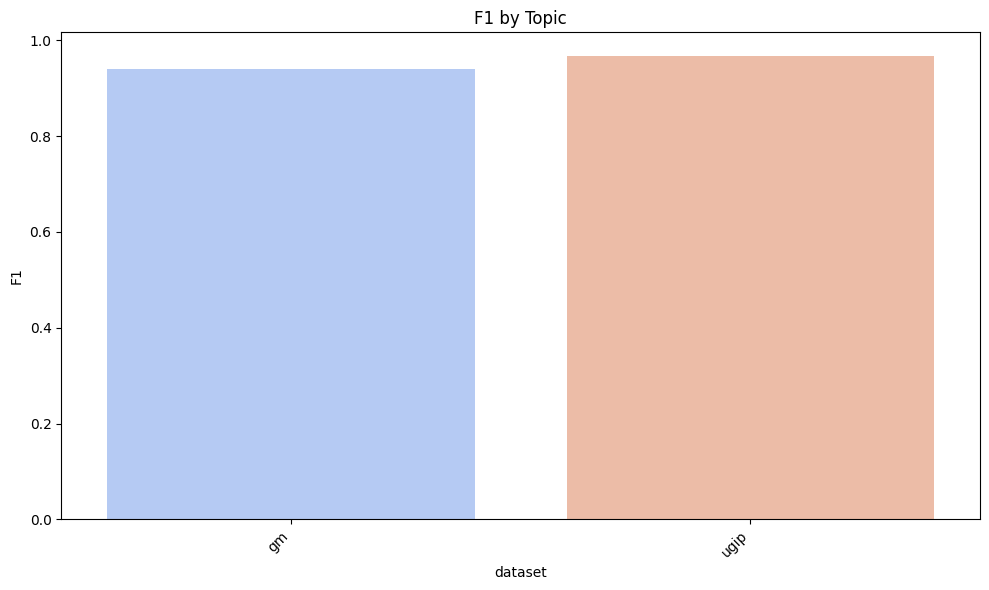

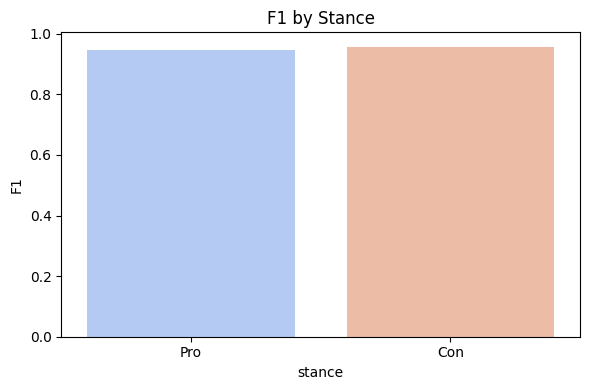

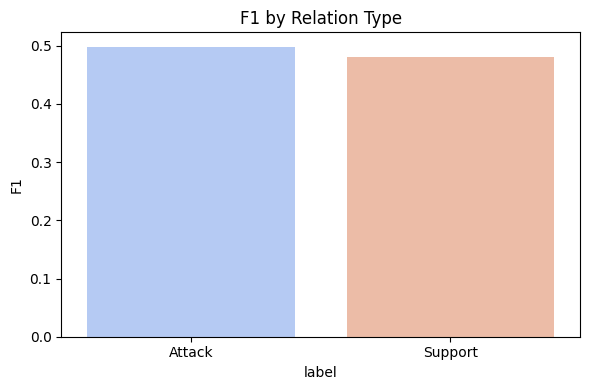

In [16]:
metrics = ['f1']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=topic_prf1_df, x='dataset', y=metric, palette='coolwarm')
    plt.title(f'{metric.capitalize()} by Topic')
    plt.ylabel(f'{metric.capitalize()}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

for metric in metrics:
    plt.figure(figsize=(6, 4))
    sns.barplot(data=stance_prf1_df, x='stance', y=metric, palette='coolwarm')
    plt.title(f'{metric.capitalize()} by Stance')
    plt.ylabel(f'{metric.capitalize()}')
    plt.tight_layout()
    plt.show()
    
for metric in metrics:
    plt.figure(figsize=(6, 4))
    sns.barplot(data=support_attack_prf1_df, x='label', y=metric, palette='coolwarm')
    plt.title(f'{metric.capitalize()} by Relation Type')
    plt.ylabel(f'{metric.capitalize()}')
    plt.tight_layout()
    plt.show()


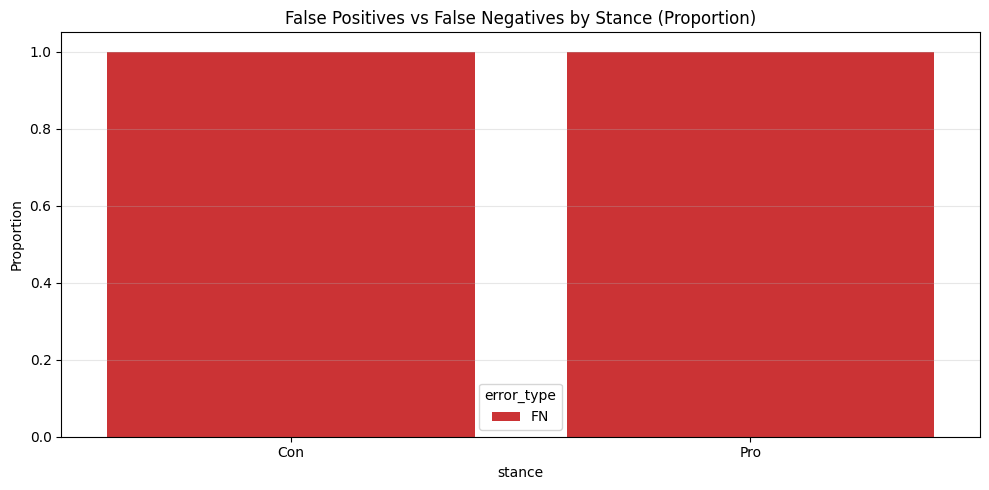

In [17]:
fp_fn_cases = all_cases[all_cases['error_type'].isin(['FP', 'FN'])]

stance_errors = fp_fn_cases.groupby(['stance', 'error_type']).size().reset_index(name='count')

stance_errors_total = stance_errors.groupby('stance')['count'].transform('sum')
stance_errors['proportion'] = stance_errors['count'] / stance_errors_total

plt.figure(figsize=(10, 5))
sns.barplot(data=stance_errors, x='stance', y='proportion', hue='error_type', palette='Set1')
plt.title("False Positives vs False Negatives by Stance (Proportion)")
plt.ylabel("Proportion")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Quantitative analysis

In [18]:
### 1. Effect of Argument Frequency on Accuracy

arg_counts = all_cases['argument'].value_counts().reset_index()
arg_counts.columns = ['argument', 'frequency']

arg_accuracy = all_cases.groupby('argument').apply(
    lambda x: (x['gold'] == x['pred']).mean()
).reset_index()
arg_accuracy.columns = ['argument', 'accuracy']

arg_analysis = pd.merge(arg_counts, arg_accuracy, on='argument')

corr, p_value = pearsonr(arg_analysis['frequency'], arg_analysis['accuracy'])
print(f"Correlation between argument frequency and accuracy: {corr:.4f} (p={p_value:.4f})")

Correlation between argument frequency and accuracy: 0.6276 (p=0.0217)


- Stronger positive effect of frequency

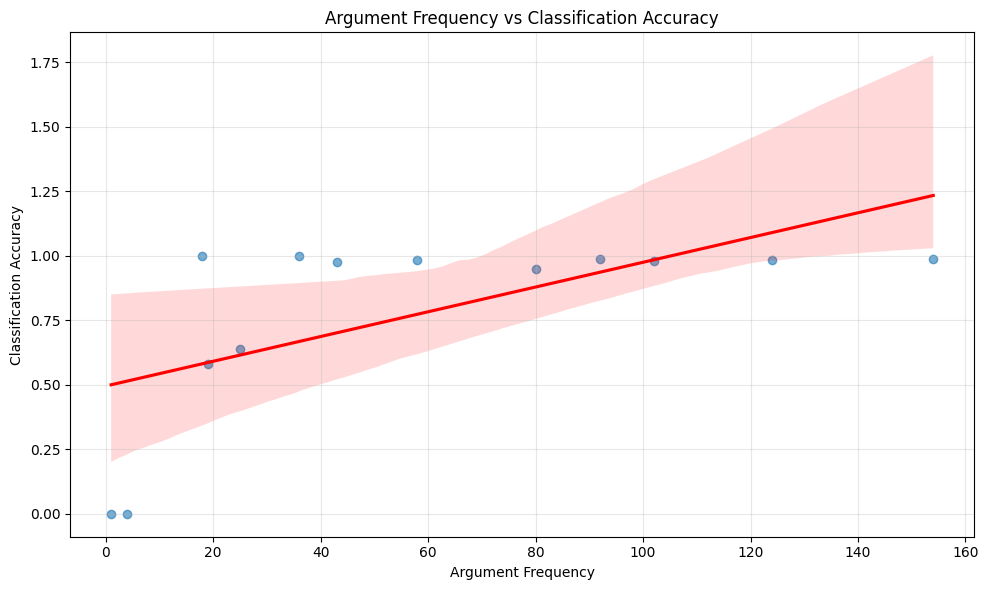

In [19]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=arg_analysis, 
    x='frequency', 
    y='accuracy', 
    scatter_kws={'alpha':0.6}, 
    line_kws={'color':'red'}
)
plt.xlabel('Argument Frequency')
plt.ylabel('Classification Accuracy')
plt.title('Argument Frequency vs Classification Accuracy')
plt.grid(True, alpha=0.3)
plt.tight_layout()

- Argument frequency appears to have a significant effect here

In [ ]:
### 2. Single Argument Performance

worst_args = arg_analysis.sort_values('accuracy').head(10)
best_args = arg_analysis.sort_values('accuracy', ascending=False).head(10)


arg_topics = all_cases.groupby('argument')['dataset'].first().reset_index()
arg_analysis = pd.merge(arg_analysis, arg_topics, on='argument')

topic_counts = all_cases['dataset'].value_counts().reset_index()
topic_counts.columns = ['dataset', 'topic_total']

arg_analysis = pd.merge(arg_analysis, topic_counts, on='dataset')

arg_analysis['topic_proportion'] = arg_analysis['frequency'] / arg_analysis['topic_total']

worst_args = arg_analysis.sort_values('accuracy').head(10)[['argument', 'accuracy', 'frequency', 'topic_proportion', 'dataset']]
best_args = arg_analysis.sort_values('accuracy', ascending=False).head(10)[['argument', 'accuracy', 'frequency', 'topic_proportion', 'dataset']]

In [21]:
worst_args

,argument,accuracy,frequency,topic_proportion,dataset
11,Likely to be seen as a state sanctioned condem...,0.000000,4,0.012422,ugip
12,Implies ultimate power on the part of the state,0.000000,1,0.003106,ugip
9,Gay couples can declare their union without re...,0.578947,19,0.043779,gm
8,Gay couples should be able to take advantage o...,0.640000,25,0.057604,gm
4,Major world religions are against gay marriages,0.950000,80,0.184332,gm
6,Removing under god would promote religious tol...,0.976744,43,0.133540,ugip
2,It is discriminatory to refuse gay couples the...,0.980392,102,0.235023,gm
5,America is based on democracy and the pledge s...,0.982759,58,0.180124,ugip
1,Separation of state and religion,0.983871,124,0.385093,ugip
0,Marriage should be between a man and a woman,0.987013,154,0.354839,gm


In [22]:
best_args

,argument,accuracy,frequency,topic_proportion,dataset
7,"Marriage is about more than procreation, there...",1.000000,36,0.082949,gm
10,Gay marriage undermines the institution of mar...,1.000000,18,0.041475,gm
3,Under God is part of American tradition and h...,0.989130,92,0.285714,ugip
0,Marriage should be between a man and a woman,0.987013,154,0.354839,gm
1,Separation of state and religion,0.983871,124,0.385093,ugip
5,America is based on democracy and the pledge s...,0.982759,58,0.180124,ugip
2,It is discriminatory to refuse gay couples the...,0.980392,102,0.235023,gm
6,Removing under god would promote religious tol...,0.976744,43,0.133540,ugip
4,Major world religions are against gay marriages,0.950000,80,0.184332,gm
8,Gay couples should be able to take advantage o...,0.640000,25,0.057604,gm


In [23]:
stance_accuracy = all_cases.groupby('stance').apply(
    lambda x: (x['gold'] == x['pred']).mean()
).reset_index()
stance_accuracy.columns = ['stance', 'accuracy']

# Error types by stance
stance_errors = all_cases.groupby(['stance', 'error_type']).size().unstack().fillna(0)
stance_errors_pct = stance_errors.div(stance_errors.sum(axis=1), axis=0)

# Number of predictions by stance and prediction
stance_preds = pd.crosstab(all_cases['stance'], all_cases['pred'])
stance_preds_pct = stance_preds.div(stance_preds.sum(axis=1), axis=0)

print("Accuracy by stance:")
print(stance_accuracy)
print("\nPrediction distribution by stance:")
print(stance_preds_pct)

Accuracy by stance:
  stance  accuracy
0    Con  0.958998
1    Pro  0.946372

Prediction distribution by stance:
pred           1         5
stance                    
Con     0.412301  0.587699
Pro     0.454259  0.545741


In [ ]:
dataset_accuracy = all_cases.groupby('dataset').apply(
    lambda x: (x['gold'] == x['pred']).mean()
).reset_index()
dataset_accuracy.columns = ['dataset', 'accuracy']

# Error types by dataset
dataset_errors = all_cases.groupby(['dataset', 'error_type']).size().unstack().fillna(0)
dataset_errors_pct = dataset_errors.div(dataset_errors.sum(axis=1), axis=0)

dataset_stance_accuracy = all_cases.groupby(['dataset', 'stance']).apply(
    lambda x: (x['gold'] == x['pred']).mean()
).reset_index()
dataset_stance_accuracy.columns = ['dataset', 'stance', 'accuracy']

print("Accuracy by dataset:")
print(dataset_accuracy)
print("\nError type distribution by dataset:")
print(dataset_errors_pct)

Accuracy by dataset:
  dataset  accuracy
0      gm  0.942396
1    ugip  0.968944

Error type distribution by dataset:
error_type        FN   correct
dataset                       
gm          0.057604  0.942396
ugip        0.031056  0.968944


<Figure size 1200x600 with 0 Axes>

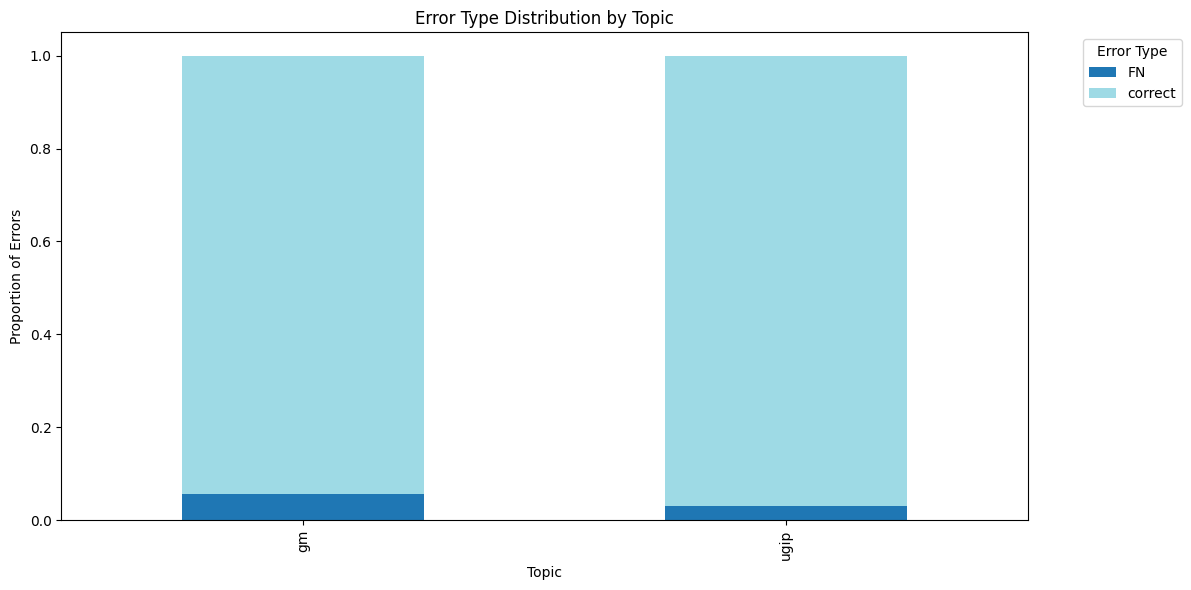

In [25]:
plt.figure(figsize=(12, 6))
dataset_errors_pct.plot(kind='bar', stacked=True, colormap='tab20', figsize=(12, 6))
plt.title('Error Type Distribution by Topic')
plt.xlabel('Topic')
plt.ylabel('Proportion of Errors')
plt.legend(title='Error Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

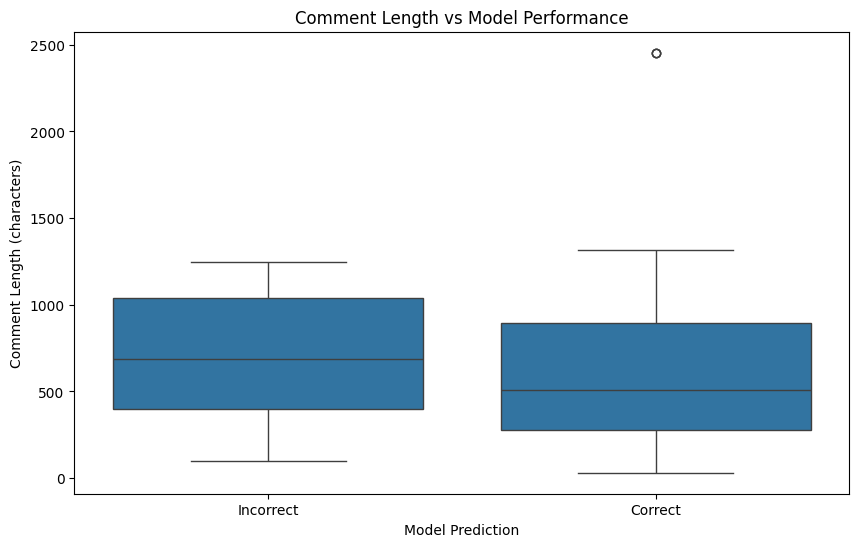

In [26]:
all_cases["comment_length"] = all_cases["comment"].str.len()
all_cases = all_cases[all_cases['comment'].str.len() <= 5000]

all_cases["is_correct"] = all_cases["error_type"].apply(lambda x: 1 if x == "correct" else 0)
plt.figure(figsize=(10, 6))
sns.boxplot(data=all_cases, x="is_correct", y="comment_length")
plt.xticks([0, 1], ["Incorrect", "Correct"])
plt.xlabel("Model Prediction")
plt.ylabel("Comment Length (characters)")
plt.title("Comment Length vs Model Performance")
plt.show()

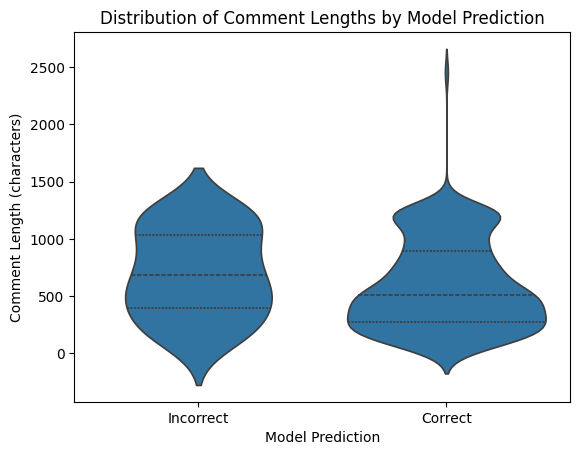

In [27]:
sns.violinplot(data=all_cases, x="is_correct", y="comment_length", inner="quartile")
plt.xticks([0, 1], ["Incorrect", "Correct"])
plt.xlabel("Model Prediction")
plt.ylabel("Comment Length (characters)")
plt.title("Distribution of Comment Lengths by Model Prediction")
plt.show()

In [28]:
from scipy.stats import ttest_ind

correct_lengths = all_cases[all_cases["is_correct"] == 1]["comment_length"]
incorrect_lengths = all_cases[all_cases["is_correct"] == 0]["comment_length"]

t_stat, p_value = ttest_ind(correct_lengths, incorrect_lengths, equal_var=False)
print(f"T-test result: t={t_stat:.3f}, p={p_value:.4f}")

T-test result: t=-1.590, p=0.1203


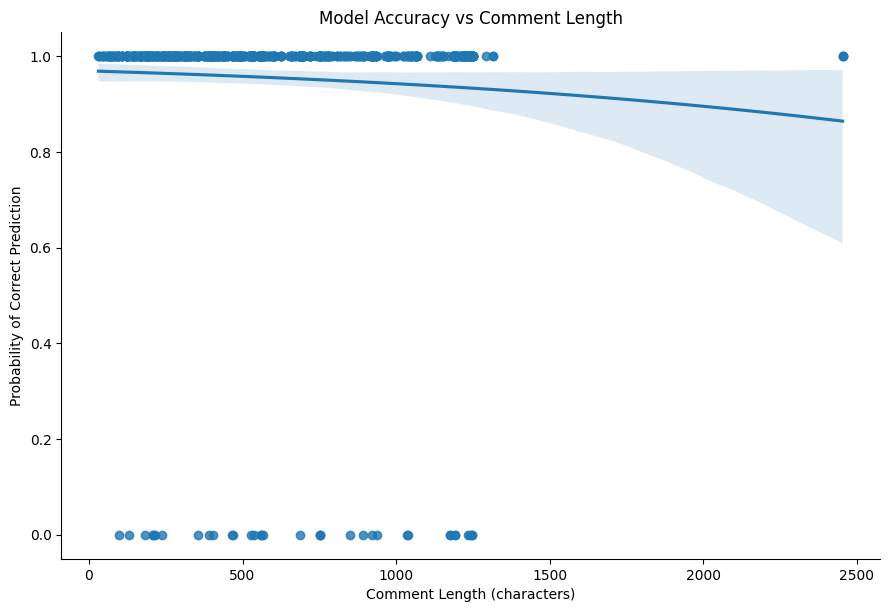

In [29]:
sns.lmplot(data=all_cases, x="comment_length", y="is_correct", logistic=True, height=6, aspect=1.5)
plt.xlabel("Comment Length (characters)")
plt.ylabel("Probability of Correct Prediction")
plt.title("Model Accuracy vs Comment Length")
plt.show()

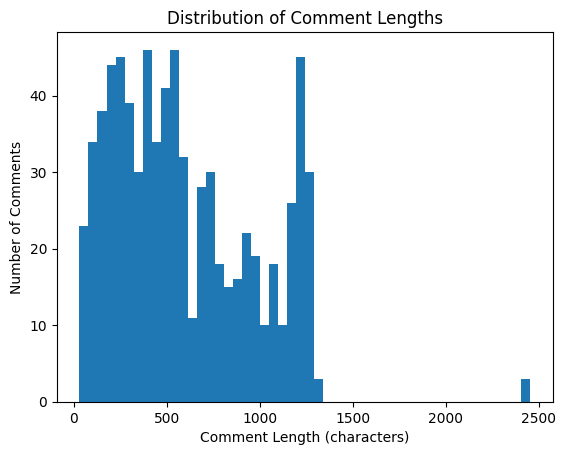

In [30]:
all_cases['comment_length'] = all_cases['comment'].str.len()

plt.hist(all_cases['comment_length'], bins=50)
plt.xlabel('Comment Length (characters)')
plt.ylabel('Number of Comments')
plt.title('Distribution of Comment Lengths')
plt.show()

- We excluded the top 5% longest comments (over 3000 characters) to reduce the influence of outliers. The logistic regression model shows a clear inverse relationship between comment length and model accuracy, with shorter comments more likely to be classified correctly. Although the per-character drop is small, over hundreds/thousands of characters, the effect becomes meaningful

# Qualitative analysis

In [31]:
error_samples = all_cases[all_cases['error_type'].isin(['FP', 'FN'])].groupby('dataset').apply(
    lambda x: x.sample(min(8, len(x)))
).reset_index(drop=True)

os.makedirs("qualitative_analysis", exist_ok=True)
error_samples.to_csv("qualitative_analysis/error_samples_t3.csv", index=False, encoding='utf-8')

In [32]:
error_samples

,dataset,split,id,gold,pred,error_type,argument,stance,comment,comment_length,is_correct
0,gm,0,18arg1,5,1,FN,Gay couples can declare their union without re...,Con,Different people have different thoughts about...,354,0
1,gm,0,7arg1,5,1,FN,Gay couples can declare their union without re...,Con,Absolutely No. Who are we to rewrite the creat...,208,0
2,gm,0,173arg7,5,1,FN,Marriage should be between a man and a woman,Con,You will never change people's minds about the...,1177,0
3,gm,0,60arg2,5,1,FN,Gay couples should be able to take advantage o...,Pro,I do believe that if you love each other that ...,753,0
4,gm,0,117arg1,5,1,FN,Gay couples can declare their union without re...,Con,No one can dictate who one loves. That is not ...,391,0
5,gm,0,78arg1,5,1,FN,Gay couples can declare their union without re...,Con,I'm con because gay marriage is against the mo...,851,0
6,gm,0,148arg1,5,1,FN,Gay couples can declare their union without re...,Con,The ideal setting in which to raise a child is...,1246,0
7,gm,0,164arg4,5,1,FN,It is discriminatory to refuse gay couples the...,Pro,"Well'if we start legalizing gay marriage,that ...",1192,0
8,ugip,0,414721990arg5,5,1,FN,Implies ultimate power on the part of the state,Con,The phrase 'under God' acts as a limit on what...,1242,0
9,ugip,0,414721839arg4,5,1,FN,Likely to be seen as a state sanctioned condem...,Pro,I do believe that under God should be left in ...,405,0
